In [124]:
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

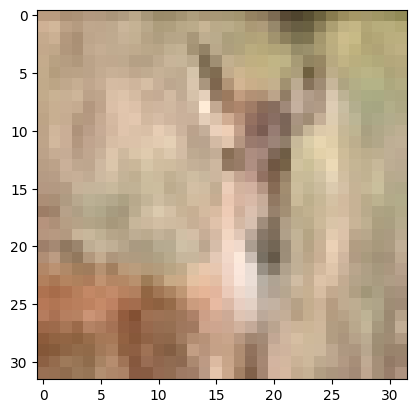

In [68]:
ftype = "test"
fn = "ffc43a6.jpg"

img = Image.open(f"{ftype}_ims/{fn}")
plt.imshow(img)

In [69]:
def read_data(mode="train", p=0.2, seed=None):
    """
    Read the training/testing files and return the input data and labels.

    Parameters:
    ----------
    mode (str): 'train' or 'test' to read the training or testing data.
    p (float): fraction of the data to read. Useful for debugging.
    seed (int): random seed to use for reproducibility.

    Returns:
    -------
    X (np.array): input data
    y (np.array): labels
    """
    if mode == "train" or mode == "test":
        data = pd.read_csv('train.csv')
        mode = "train"
    elif mode == "predict":
        data = pd.read_csv('test.csv')
        mode = "test"
    else:
        raise ValueError("mode must be 'train' or 'test' or 'predict'")

    if seed is None:data = data.sample(frac=p)
    else: data = data.sample(frac=p, random_state=seed)

    X = data['im_name'].apply(lambda filename: np.asarray(Image.open(f"{mode}_ims/{filename}"))).values
    y = data['label'].values
    X = np.stack(X).reshape(-1, 32*32*3)

    return X, y

In [121]:
trainData, trainLabels = read_data("train", p=0.2, seed=69)
testData, testLabels = read_data("test", p=0.2, seed=69)
trainData.shape, trainLabels.shape, testData.shape, testLabels.shape

((10000, 3072), (10000,), (10000, 3072), (10000,))

In [122]:
trainData_red = trainData.reshape(-1, 32, 32, 3)[:, :, :, 0].reshape(-1, 32*32)
trainData_green = trainData.reshape(-1, 32, 32, 3)[:, :, :, 1].reshape(-1, 32*32)
trainData_blue = trainData.reshape(-1, 32, 32, 3)[:, :, :, 2].reshape(-1, 32*32)
trainData_greyScale = 0.2989 * trainData_red + 0.5870 * trainData_green + 0.1140 * trainData_blue
trainData_bg = 0.5 * trainData_blue + 0.5 * trainData_green

testData_red = testData.reshape(-1, 32, 32, 3)[:, :, :, 0].reshape(-1, 32*32)
testData_green = testData.reshape(-1, 32, 32, 3)[:, :, :, 1].reshape(-1, 32*32)
testData_blue = testData.reshape(-1, 32, 32, 3)[:, :, :, 2].reshape(-1, 32*32)
testData_greyScale = 0.2989 * testData_red + 0.5870 * testData_green + 0.1140 * testData_blue
testData_bg = 0.5 * testData_blue + 0.5 * testData_green

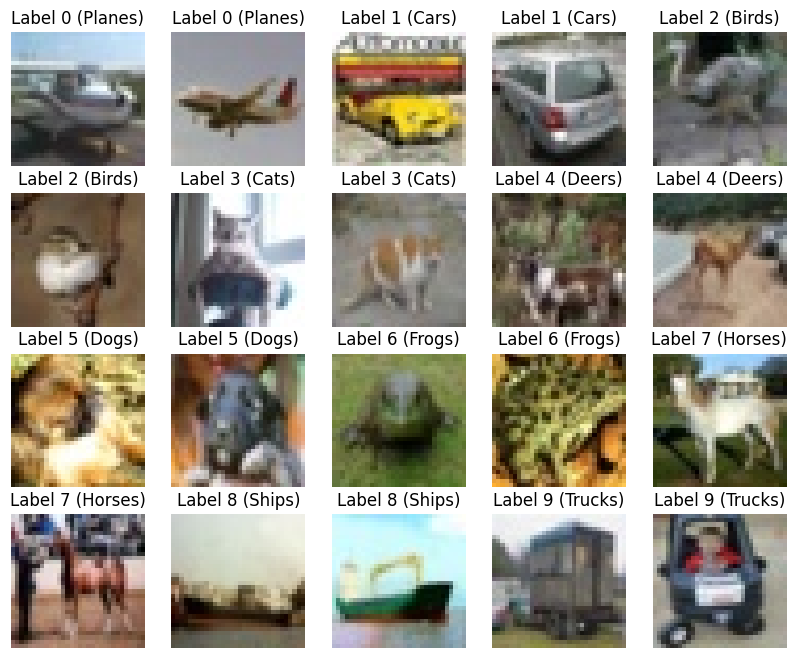

In [72]:
# Plot 2 sample images from the training set from each label
i2label = ["Planes", "Cars", "Birds", "Cats", "Deers", "Dogs", "Frogs", "Horses", "Ships", "Trucks"]
fig, ax = plt.subplots(4, 5, figsize=(10, 8))
for i in range(20):
    ax[i//5, i%5].imshow(trainData[trainLabels == i//2][i%2].reshape(32, 32, 3))
    ax[i//5, i%5].set_title(f"Label {i//2} ({i2label[i//2]})")
    ax[i//5, i%5].axis('off')

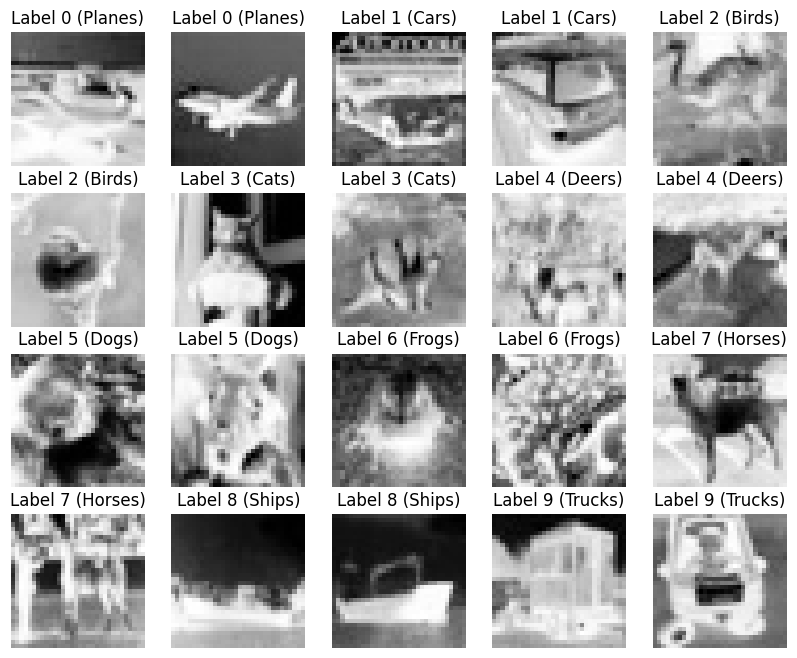

In [73]:
# Plot 2 sample images from the training set from each label (only red)
fig, ax = plt.subplots(4, 5, figsize=(10, 8))
for i in range(20):
    ax[i//5, i%5].imshow(trainData_greyScale[trainLabels == i//2][i%2].reshape(32, 32), cmap='Greys')
    ax[i//5, i%5].set_title(f"Label {i//2} ({i2label[i//2]})")
    ax[i//5, i%5].axis('off')

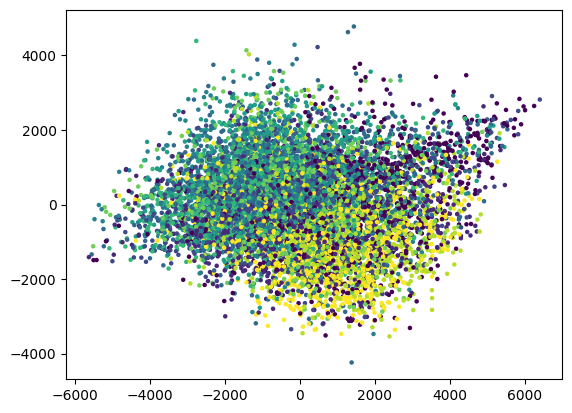

In [74]:
# Use T-SNE to visualize the data
pca = PCA(n_components=2)
trainData_pca = pca.fit_transform(trainData)
plt.scatter(trainData_pca[:, 0], trainData_pca[:, 1], c=trainLabels, cmap='viridis', s=5)

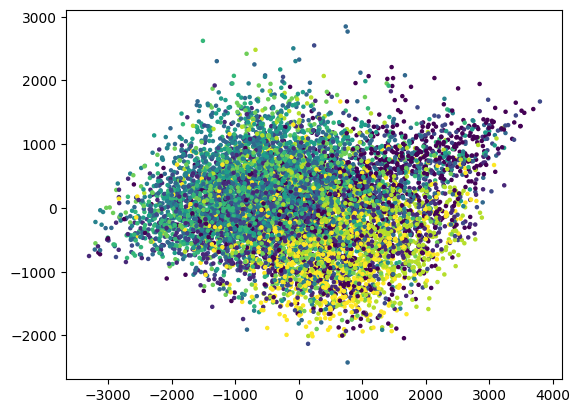

In [75]:
# Use T-SNE to visualize the data (only red)
pcs = PCA(n_components=2)
trainData_pca = pcs.fit_transform(0.5*trainData_blue + 0.5*trainData_green)
plt.scatter(trainData_pca[:, 0], trainData_pca[:, 1], c=trainLabels, cmap='viridis', s=5)

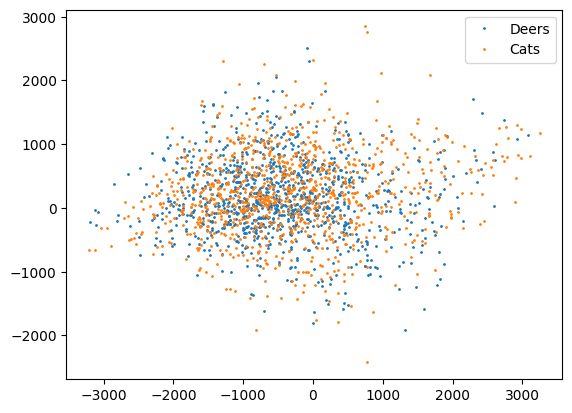

In [76]:
# Split the labels into 2 groups, then visualize it
group1 = [4]
group2 = [3]
tr1 = sum([trainLabels == i for i in group1])
tr2 = sum([trainLabels == i for i in group2])
plt.plot(trainData_pca[tr1 == 1, 0], trainData_pca[tr1 == 1, 1], '.', label=', '.join(i2label[i] for i in group1), markersize=2)
plt.plot(trainData_pca[tr2 == 1, 0], trainData_pca[tr2 == 1, 1], '.', label=', '.join(i2label[i] for i in group2), markersize=2)
plt.legend()

In [103]:
def getBinaryClassifier(model, trainData, trainLabels, group1, group2, testData=None, testLabels=None):
    """
    Fits a binary classifier that distinguishes between the two groups of labels.

    Parameters:
    ----------
    model (any): a learning model
    group1 (list): list of labels to group together
    group2 (list): list of labels to group together
    seed (int): random seed to use for reproducibility.

    Returns:
    -------
    clf (any): the trained classifier
    filteredData (np.array): the data used to train the classifier
    filteredLabels (np.array): the labels used to train the classifier
    pca (PCA): the PCA object used to transform the data
    """
    assert len(group1), "Group 1 must not be empty"
    assert len(group2), "Group 2 must not be empty"
    assert all([i not in group2 for i in group1]), "Two groups must not overlap"
    assert trainData.shape[0] == trainLabels.shape[0], "Data and labels must have the same length"

    filteredData = trainData[np.isin(trainLabels, group1 + group2)]
    filteredLabels = trainLabels[np.isin(trainLabels, group1 + group2)]
    filteredLabels = np.where(np.isin(filteredLabels, group1), 0, 1)

    pca = PCA(n_components=40)
    filteredData = pca.fit_transform(filteredData)

    clf = model
    clf.fit(filteredData, filteredLabels)
    train_scores = cross_val_score(clf, filteredData, filteredLabels, cv=5)
    train_acc = (clf.predict(filteredData) == filteredLabels).mean()
    
    test_acc = None
    if testData is not None and testLabels is not None:
        assert testData.shape[0] == testLabels.shape[0], "Data and labels must have the same length"
        testData = testData[np.isin(testLabels, group1 + group2)]
        testLabels = testLabels[np.isin(testLabels, group1 + group2)]
        testLabels = np.where(np.isin(testLabels, group1), 0, 1)
        
        testData = pca.transform(testData)
        
        test_scores = cross_val_score(clf, testData, testLabels, cv=5)
        test_acc = (clf.predict(testData) == testLabels).mean()
    
    print(f"Train scores: {train_scores.mean():.4f} +/- {train_scores.std():.4f}, Train accuracy: {train_acc:.4f}")
    if testData is not None and testLabels is not None:
        print(f"Test scores: {test_scores.mean():.4f} +/- {test_scores.std():.4f}, Test accuracy: {test_acc:.4f}")
    
    return clf, filteredData, filteredLabels, pca, train_acc, test_acc

In [104]:
def plotDB(model, data, label, text_label, eps=1, smooth=True):
    """
    Plot the decision boundary of a binary model.

    Parameters:
    ----------
    model (any): a trained model
    data (np.array): input data
    label (np.array): labels
    i2label (list): list of labels that will be displayed on the plot
    eps (float): epsilon for the meshgrid
    smooth (bool): whether to plot the decision boundary smoothly
    pca (PCA): the PCA object used to transform the data

    Returns:
    -------
    None
    """
    assert data.shape[0] == label.shape[0]

    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)

    x_min, x_max = data_pca[:, 0].min() - 4*eps, data_pca[:, 0].max() + 4*eps
    y_min, y_max = data_pca[:, 1].min() - 4*eps, data_pca[:, 1].max() + 4*eps
    xx, yy = np.meshgrid(np.arange(x_min, x_max, eps), np.arange(y_min, y_max, eps))
    if smooth: Z = model.predict_proba(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))[:, 0]
    else: Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, colors=["#FFA07A", "#87CEFA"], levels=[0, 0.5, 1])
    for i, l in enumerate(np.unique(label.astype(np.int32))): 
        plt.scatter(data_pca[label == l, 0], data_pca[label == l, 1], label=text_label[i], s=2)
    plt.contour(xx, yy, Z, levels=[0.5])
    plt.legend()
    plt.show()

In [79]:
# Find an optimal hyperparameter for SVM

pca = PCA(n_components=40)
size = 2000
trainData_pca_svm = pca.fit_transform(trainData_blue[:size])
trainLabels_svm = trainLabels[:size]

print("dim reduced to 40")

Cs = [0.01, 0.1, 1, 10, 100]

group = [0, 1, 8, 9]

tr = np.zeros(trainLabels_svm.shape)
for i in group:
    tr += (trainLabels_svm == i)

for C in Cs:
    svm = SVC(C=C, kernel='rbf')
    svm.fit(trainData_pca_svm, tr)
    scores = cross_val_score(svm, trainData_pca_svm, tr, cv=5)  # 5-fold cross-validation
    print(f"C={C}, Accuracy: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

"""
Conclusion: C=1 is optimal
"""

dim reduced to 40
C=0.01, Accuracy: 0.6740 (+/- 0.0117)
C=0.1, Accuracy: 0.7555 (+/- 0.0394)
C=1, Accuracy: 0.7845 (+/- 0.0162)
C=10, Accuracy: 0.7715 (+/- 0.0129)
C=100, Accuracy: 0.7615 (+/- 0.0246)


'\nConclusion: C=1 is optimal\n'

Train scores: 0.8219 +/- 0.0060, Train accuracy: 0.8638
Test scores: 0.7870 +/- 0.0254, Test accuracy: 0.8630


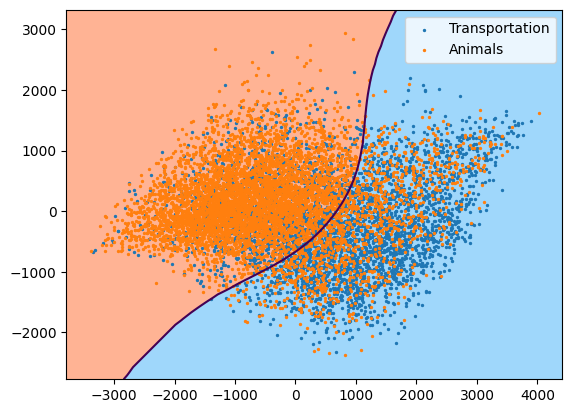

In [105]:
svm_animals2transportation, filtered_trainData, filtered_trainLabels, pca, _, _ = getBinaryClassifier(SVC(C=1, kernel='rbf', probability=True, random_state=69), 
                                                                                           trainData_blue, 
                                                                                           trainLabels, 
                                                                                           group1=[0, 1, 8, 9], 
                                                                                           group2=[2, 3, 4, 5, 6, 7],
                                                                                           testData=testData_blue,
                                                                                           testLabels=testLabels)
plotDB(svm_animals2transportation, filtered_trainData, filtered_trainLabels, ["Transportation", "Animals"], eps=100)


Train scores: 0.7209 +/- 0.0309, Train accuracy: 0.8182
Test scores: 0.6239 +/- 0.0683, Test accuracy: 0.7923


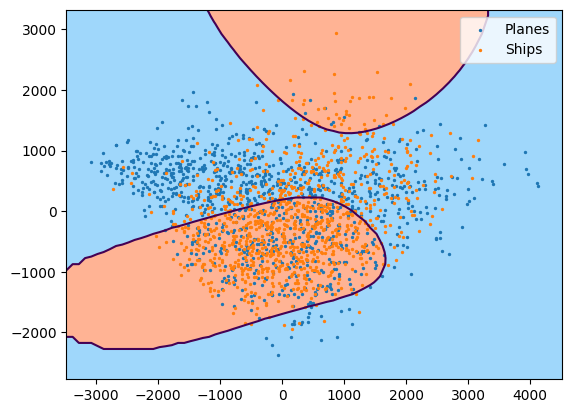

In [106]:
svm_airplane2ships, filtered_trainData, filtered_trainLabels, pca, _, _ = getBinaryClassifier(SVC(C=1, kernel='rbf', probability=True, random_state=69),
                                                                                       trainData_blue, 
                                                                                       trainLabels, 
                                                                                       group1=[0], 
                                                                                       group2=[8],
                                                                                       testData=testData_blue,
                                                                                       testLabels=testLabels)
plotDB(svm_airplane2ships, filtered_trainData, filtered_trainLabels, ["Planes", "Ships"], eps=100)

Train scores: 0.6203 +/- 0.0221, Train accuracy: 0.7895
Test scores: 0.5776 +/- 0.0791, Test accuracy: 0.7629


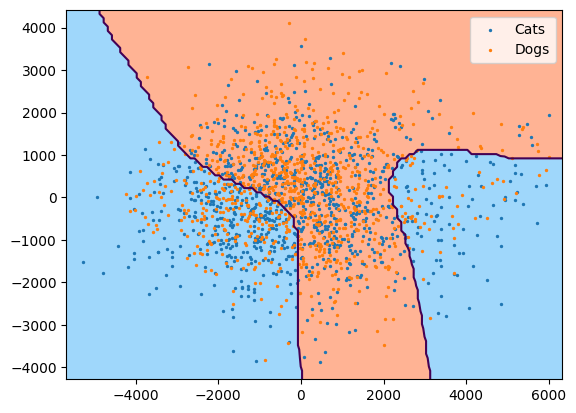

In [107]:
svm_cats2dogs, filtered_trainData, filtered_trainLabels, pca, _, _ = getBinaryClassifier(SVC(C=1, kernel='rbf', probability=True, random_state=69),
                                                                                       trainData, 
                                                                                       trainLabels, 
                                                                                       group1=[3], 
                                                                                       group2=[5],
                                                                                       testData=testData,
                                                                                       testLabels=testLabels)
plotDB(svm_cats2dogs, filtered_trainData, filtered_trainLabels, ["Cats", "Dogs"], eps=100)

In [115]:
class Model():
    def __init__(self):
        self.model = [[SVC(C=1, kernel='rbf', probability=True, random_state=69) for _ in range(i)] for i in range(10)]
        self.pca = [[None for _ in range(i)] for i in range(10)]
        self.train_acc = np.zeros((10, 10))
    def fit(self, trainData, trainLabels):
        self.train_acc = np.zeros((10, 10))
        for i in range(10):
            for j in range(i):
                print(f"Training model Group {i} vs Group {j}")
                self.model[i][j], _, _, self.pca[i][j], self.train_acc[i][j], _ = getBinaryClassifier(self.model[i][j], trainData, trainLabels, [i], [j])
        self.train_acc += self.train_acc.T
        plt.figure(figsize=(8, 8))
        plt.imshow(self.train_acc, cmap='Blues')
        for i in range(10):
            for j in range(10):
                if i == j: continue
                plt.text(j, i, f"{self.train_acc[i, j]:.2f}", ha='center', va='center', color=('black' if self.train_acc[i, j] < 0.4 else 'white'))
        plt.xticks(range(10), range(10))
        plt.yticks(range(10), range(10))
        plt.xlabel("Group 1")
        plt.ylabel("Group 2")
        plt.title("Training accuracy")
        plt.show()
    def predict(self, data, proba=False):
        assert self.pca[1][0] is not None, "Model must be fitted first"
        preds = np.zeros((data.shape[0], 10))
        for i in range(10):
            for j in range(i):
                _data = self.pca[i][j].transform(data)
                preds[:, i] += self.model[i][j].predict_proba(_data)[:, 0]
                preds[:, j] += self.model[i][j].predict_proba(_data)[:, 1]
            for j in range(i+1, 10):
                _data = self.pca[j][i].transform(data)
                preds[:, i] += self.model[j][i].predict_proba(_data)[:, 1]
                preds[:, j] += self.model[j][i].predict_proba(_data)[:, 0]
        preds /= 9
        return np.argmax(preds, axis=1) if not proba else preds
    

Training model Group 1 vs Group 0
Train scores: 0.8432 +/- 0.0096, Train accuracy: 0.9105
Training model Group 2 vs Group 0
Train scores: 0.8211 +/- 0.0146, Train accuracy: 0.8933
Training model Group 2 vs Group 1
Train scores: 0.8845 +/- 0.0117, Train accuracy: 0.9418
Training model Group 3 vs Group 0
Train scores: 0.8545 +/- 0.0137, Train accuracy: 0.9059
Training model Group 3 vs Group 1
Train scores: 0.8571 +/- 0.0194, Train accuracy: 0.9224
Training model Group 3 vs Group 2
Train scores: 0.7764 +/- 0.0125, Train accuracy: 0.8719
Training model Group 4 vs Group 0
Train scores: 0.8479 +/- 0.0117, Train accuracy: 0.8957
Training model Group 4 vs Group 1
Train scores: 0.8867 +/- 0.0138, Train accuracy: 0.9419
Training model Group 4 vs Group 2
Train scores: 0.6652 +/- 0.0200, Train accuracy: 0.7930
Training model Group 4 vs Group 3
Train scores: 0.7757 +/- 0.0219, Train accuracy: 0.8686
Training model Group 5 vs Group 0
Train scores: 0.8775 +/- 0.0070, Train accuracy: 0.9239
Training m

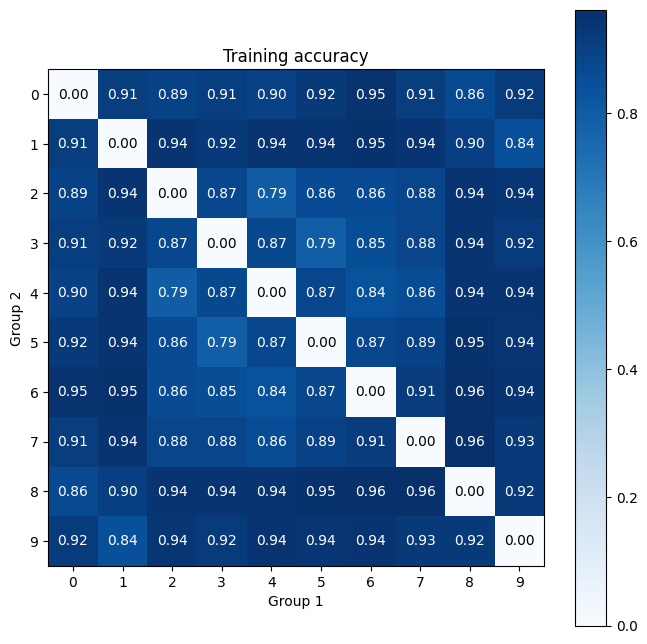

In [116]:
model = Model()
model.fit(trainData, trainLabels)

In [123]:
test_acc = (model.predict(testData) == testLabels).mean()
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.6128


In [119]:
model.predict(testData[:10], proba=True)

array([[1.25207041, 1.1954857 , 0.77753045, 1.72630626, 0.37475063,
        1.03731398, 0.3221022 , 0.54235377, 1.39472641, 1.37736019],
       [1.52566688, 1.3486257 , 0.85016625, 0.45671397, 0.77212408,
        0.22055856, 0.28303969, 0.99640421, 1.68539038, 1.86131028],
       [1.85181574, 0.50528132, 1.26525024, 1.03535892, 1.46758475,
        0.60847775, 0.7580754 , 0.89756682, 1.11176289, 0.49882617],
       [0.56869333, 0.62302336, 1.48024241, 1.22970785, 1.65888748,
        1.27903013, 1.59808219, 1.16976604, 0.08527524, 0.30729197],
       [0.42855663, 0.89826781, 0.50845077, 1.08241272, 1.29670656,
        1.22814399, 1.71394648, 1.55174906, 0.17330652, 1.11845945],
       [0.44513263, 0.72099705, 1.58081052, 0.93355263, 1.62440498,
        1.14244581, 1.80985271, 1.13255204, 0.07227674, 0.53797489],
       [1.12744863, 1.73448304, 0.59835661, 0.64676253, 0.88748294,
        0.97428276, 0.62263509, 0.38200845, 1.52202475, 1.5045152 ],
       [1.58449835, 1.27639255, 0.5920975

In [125]:
confusion_matrix(testLabels, model.predict(testData))

array([[637,  43,  40,  24,  25,  12,  21,  34, 131,  52],
       [ 27, 702,  17,  27,  13,  14,  22,  27,  47, 119],
       [ 78,  22, 465,  46, 126,  34,  99,  58,  28,  21],
       [ 33,  36,  62, 553,  48, 101,  85,  35,  29,  40],
       [ 69,  22, 106,  49, 488,  35, 129,  85,  30,  20],
       [ 21,  16,  69, 103,  48, 510,  69,  54,  28,  22],
       [  8,  22,  54,  55,  85,  31, 587,  25,  15,  26],
       [ 30,  20,  50,  45,  80,  21,  37, 673,  20,  51],
       [ 75,  57,  14,  12,  12,  13,   9,  12, 762,  50],
       [ 36,  91,  15,  21,  11,  17,  22,  26,  53, 751]], dtype=int64)

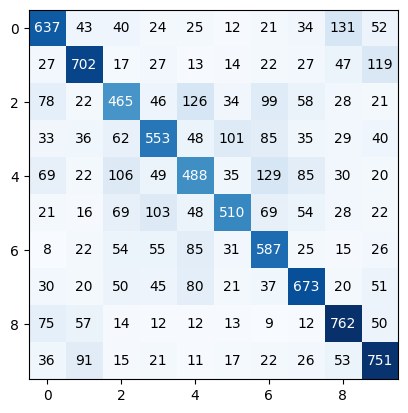

In [127]:
cm = np.array([[637,  43,  40,  24,  25,  12,  21,  34, 131,  52],
       [ 27, 702,  17,  27,  13,  14,  22,  27,  47, 119],
       [ 78,  22, 465,  46, 126,  34,  99,  58,  28,  21],
       [ 33,  36,  62, 553,  48, 101,  85,  35,  29,  40],
       [ 69,  22, 106,  49, 488,  35, 129,  85,  30,  20],
       [ 21,  16,  69, 103,  48, 510,  69,  54,  28,  22],
       [  8,  22,  54,  55,  85,  31, 587,  25,  15,  26],
       [ 30,  20,  50,  45,  80,  21,  37, 673,  20,  51],
       [ 75,  57,  14,  12,  12,  13,   9,  12, 762,  50],
       [ 36,  91,  15,  21,  11,  17,  22,  26,  53, 751]])

plt.imshow(cm, cmap='Blues')
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha='center', va='center', color=('black' if cm[i, j] < 400 else 'white'))

In [120]:
testLabels[:10]

array([3, 0, 0, 4, 1, 6, 1, 8, 2, 9], dtype=int64)

In [128]:
class Model2():
    def __init__(self):
        self.model = [SVC(C=1, kernel='rbf', probability=True, random_state=69) for i in range(10)]
        self.pca = [None for i in range(10)]
        self.train_acc = np.zeros(10)
        self.test_acc = np.zeros(10)
    def fit(self, trainData, trainLabels):
        for i in range(10):
            print(f"Training model Group {i} vs not Group {i}")
            self.model[i], _, _, self.pca[i], self.train_acc[i], self.test_acc[i] = getBinaryClassifier(self.model[i], trainData, trainLabels, [i], [j for j in range(10) if j != i])
        plt.plot(range(10), self.train_acc, 'o', label="Train")
        plt.plot(range(10), self.test_acc, 'o', label="Test")
        plt.xlabel("Group")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Training accuracy")
    def predict(self, data, proba=False):
        assert self.pca[0] is not None, "Model must be fitted first"
        preds = np.zeros((data.shape[0], 10))
        for i in range(10):
            _data = self.pca[i].transform(data)
            preds[:, i] += self.model[i].predict_proba(_data)[:, 0]
        return np.argmax(preds, axis=1) if not proba else preds
    

Training model Group 0 vs not Group 0
Train scores: 0.9152 +/- 0.0022, Train accuracy: 0.9233
Training model Group 1 vs not Group 1
Train scores: 0.9092 +/- 0.0032, Train accuracy: 0.9284
Training model Group 2 vs not Group 2
Train scores: 0.9023 +/- 0.0002, Train accuracy: 0.9033
Training model Group 3 vs not Group 3
Train scores: 0.8978 +/- 0.0002, Train accuracy: 0.8999
Training model Group 4 vs not Group 4
Train scores: 0.8972 +/- 0.0005, Train accuracy: 0.8977
Training model Group 5 vs not Group 5
Train scores: 0.9109 +/- 0.0017, Train accuracy: 0.9155
Training model Group 6 vs not Group 6
Train scores: 0.9093 +/- 0.0002, Train accuracy: 0.9109
Training model Group 7 vs not Group 7
Train scores: 0.9061 +/- 0.0013, Train accuracy: 0.9153
Training model Group 8 vs not Group 8
Train scores: 0.9222 +/- 0.0055, Train accuracy: 0.9379
Training model Group 9 vs not Group 9
Train scores: 0.9069 +/- 0.0017, Train accuracy: 0.9230


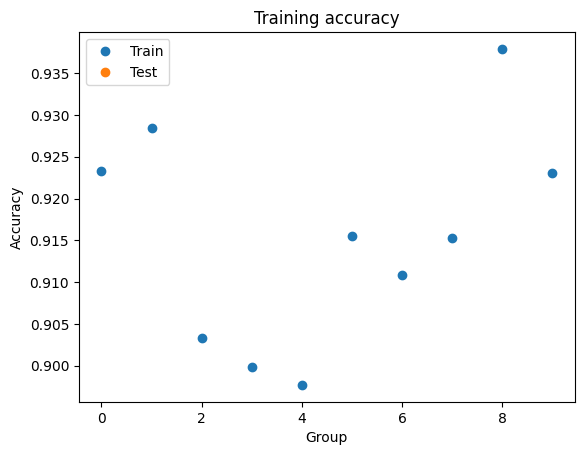

In [129]:
model2 = Model2()
model2.fit(trainData, trainLabels)

In [130]:
p2 = model2.predict(testData, proba=True)
test_acc = (np.argmax(p2, axis=1) == testLabels).mean()
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.7705


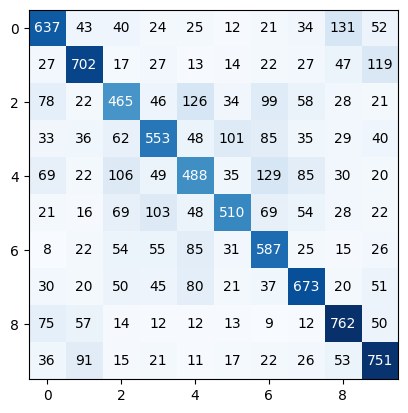

In [131]:
confusion_matrix(testLabels, np.argmax(p2, axis=1))
plt.imshow(cm, cmap='Blues')
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha='center', va='center', color=('black' if cm[i, j] < 400 else 'white'))